In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# batch, N, timeout, num_cpus, sleep
data = {
    
}
    

BATCH = "batch"
N_ENTRY = "N"
TIMEOUT = "timeout"
NUM_CPUS = "num_cpus"
SLEEP = "sleep"
    
def Set(batch = None, N = None, timeout = None, num_cpus = None, sleep = None, v = None, attack_p = None):
    if v == None:
        raise Exception("V must be a value")
    global data
    if batch not in data:
        data[batch] = {}
    if N not in data[batch]:
        data[batch][N] = {}
    if timeout not in data[batch][N]:
        data[batch][N][timeout] = {}
    if num_cpus not in data[batch][N][timeout]:
        data[batch][N][timeout][num_cpus] = {}
    if sleep in data[batch][N][timeout][num_cpus]:
        rep = 2
        if 'repetition' in data[batch][N][timeout][num_cpus][sleep]:
            data[batch][N][timeout][num_cpus][sleep]['repetition'] += 1
            rep = data[batch][N][timeout][num_cpus][sleep]['repetition']
        else:
            rep = data[batch][N][timeout][num_cpus][sleep]['repetition'] = 2
        
        data[batch][N][timeout][num_cpus][sleep]['total time'] = (data[batch][N][timeout][num_cpus][sleep]['total time'] * (rep-1) + v['total time']) / rep
        data[batch][N][timeout][num_cpus][sleep]['avg latency'] = (data[batch][N][timeout][num_cpus][sleep]['avg latency'] * (rep-1) + v['avg latency']) / rep
    else:
        data[batch][N][timeout][num_cpus][sleep] = v
    
    data[batch][N][timeout][num_cpus][sleep]['attack_p'] = attack_p

def Get(batch = None, N = None, timeout = None, num_cpus = None, sleep = None):
    return data[batch][N][timeout][num_cpus][sleep]

def Clear():
    global data
    data = {}

def Exists(batch = None, N = None, timeout = None, num_cpus = None, sleep = None):
    if batch not in data:
        return False
    if N not in data[batch]:
        return False
    if timeout not in data[batch][N]:
        return False
    if num_cpus not in data[batch][N][timeout]:
        return False
    if sleep not in data[batch][N][timeout][sleep]:
        return False
    return True


def GetEntry(batch = None, N = None, timeout = None, num_cpus = None, sleep = None):
    return {BATCH: batch, N_ENTRY: N, TIMEOUT: timeout, NUM_CPUS: num_cpus, SLEEP: sleep}

def GetElementFromEntry(entry):
    return Get(batch=entry[BATCH],N = entry[N_ENTRY], timeout=entry[TIMEOUT], num_cpus=entry[NUM_CPUS], sleep=entry[SLEEP])

def GetElementsFromEntryList(entries):
    ans = []
    for e in entries:
        ans += [GetElementFromEntry(e)]
    return ans

def FindKeys(batch = None, N = None, timeout = None, num_cpus = None, sleep = None):
    all_entries = []
    for b in data:
        for n in data[b]:
            for t in data[b][n]:
                for ncpu in data[b][n][t]:
                    for sl in data[b][n][t][ncpu]:
                        all_entries += [GetEntry(batch=b,N=n,timeout=t,num_cpus=ncpu,sleep=sl)]
    
    entries_tuples = [(batch,BATCH), (N,N_ENTRY), (timeout, TIMEOUT), (num_cpus,NUM_CPUS), (sleep,SLEEP)]
    for tup in entries_tuples:
        entry = tup[0]
        dict_key = tup[1]
        if entry != None:
            if not isinstance(entry,list):
                entry = [entry]
            idx_to_remove = []
            for i in range(len(all_entries)):
                elm = all_entries[i]
                if elm[dict_key] not in entry:
                    idx_to_remove += [i]
            all_entries = np.delete(all_entries,idx_to_remove)
    
    return all_entries


Clear()


In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def generate_color_list(num_colors):
    # Get a list of distinct colors from the TABLEAU_COLORS dictionary
    tableau_colors = list(mcolors.TABLEAU_COLORS.values())

    # If the number of colors requested is less than the length of tableau_colors,
    # return the first num_colors colors; otherwise, cycle through the colors
    if num_colors <= len(tableau_colors):
        return tableau_colors[:num_colors]
    else:
        color_list = []
        for i in range(num_colors):
            color_list.append(tableau_colors[i % len(tableau_colors)])
        return color_list

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import random

def line_plot(xx,yy,labels, x_label, y_label, title,
              stddev = None,
              horizontal_grid_only = None,
              file_path = None,
              curve_line = None,
              extra_y_value = None,
              extra_value_label = None,
              x_ticks = None,
              line_type = '-',
              put_point = True,
              fig_size = None
              ):
    
    n_plots = len(xx)
    if fig_size == None:
        fig_size = (15,8)
    fig, ax = plt.subplots(figsize=fig_size)

    colors = generate_color_list(n_plots)
    for i in range(n_plots):
        x = xx[i]
        y = yy[i]
        label_i = labels[i]
        
        if curve_line: 
            f = interp1d(x, y, kind='quadratic')  # 'cubic' for a smooth curve, you can try other options too

            x_new = np.linspace(min(x), max(x), 100)
            y_new = f(x_new)
            for j in range(len(y_new)):
                if y_new[j] < 0:
                    y_new[j] = 0
            plt.plot(x_new, y_new, line_type, color = colors[i])
            plt.plot(x, y, 'o', color = colors[i], label=label_i)
        else:
            plt.plot(x, y,line_type, color = colors[i], label=label_i)
            if put_point:
                plt.plot(x, y, 'o', color = colors[i])#, label=label_i)
            

        if stddev != None:
            errors = stddev[i]
            for err_idx in range(len(x)):
                plt.fill_between([x[err_idx]], [y[err_idx] - errors[err_idx]], [y[err_idx] + errors[err_idx]], color = colors[i], alpha=1)


    if extra_y_value != None:
        ax.axhline(y = extra_y_value, color = generate_color_list(10)[random.randint(0,9)], linestyle = ':', label=extra_value_label)
        plt.legend()

    plt.grid()
    if horizontal_grid_only:
        plt.grid(axis='y', which='both', linestyle='-', linewidth=0.7, alpha = 0.5)

    if x_ticks != None:
        ax.set_xticks(x_ticks)

    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if file_path != None:
        plt.savefig(file_path)
    plt.show()



In [5]:
import numpy as np
import random

def bar_plot(xx,yy, x_label, y_label, title,
              horizontal_grid_only = None,
              file_path = None,
              rotation = None,
              extra_y_value = None,
              extra_value_label = None,
              fig_size = None,
              width = None,
              y_lim = None,
              y_text = None,
              ):
    
    if fig_size == None:
        fig_size = (15,8)

    fig, ax = plt.subplots(figsize=fig_size)

    color = generate_color_list(10)[random.randint(0,9)]
    
    if width == None:
        width = 0.25  

    ax.bar(xx, yy, width, color = color)

    plt.xticks(xx)

    plt.grid()
    if horizontal_grid_only:
        plt.grid(axis='y', which='both', linestyle='-', linewidth=0.7, alpha = 0.5)

    if rotation:
        plt.xticks(rotation=15)
    
    if extra_y_value != None:
        ax.axhline(y = extra_y_value, color = generate_color_list(10)[random.randint(0,9)], linestyle = ':', label=extra_value_label)
        plt.legend()
    
    if y_lim != None:
        plt.ylim(y_lim[0],y_lim[1])

    if y_text != None:
        for i, v in enumerate(yy):

            plt.text(i,v+0.01,str(v),color='black')


    # plt.tight_layout()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if file_path != None:
        plt.savefig(file_path)
    plt.show()



In [6]:
def ConvertHistogram(hist_text: str):
    #  &[map[4.994ms - 4.998ms:2] map[4.998ms - 5.001ms:1]]
    # hist_text = hist_text.replace("ms","*pow(10,3)")
    x = []
    y = []
    args = hist_text.split("map[")
    for i in range(1,len(args)):
        field = args[i].split("]")[0]
        first_num = field.split("ms")[0]
        second_num = field.split("ms")[1].split(" - ")[1]
        mid_point = (float(first_num) + float(second_num))/2
        x += [mid_point]
        y += [int(field.split(":")[1])]
    
    return x,y

def DisplayHistogram(x,y, x_label = "Latency(ms)", y_label = "Number of Messages Verified", title = "Number of messages verified by their Latency",
              horizontal_grid_only = None,
              file_path = None,
              rotation = None,
              extra_y_value = None,
              extra_value_label = None,
              fig_size = None
              ):
    
    bar_plot(x,y, x_label, y_label, title,
              horizontal_grid_only = None,
              file_path = None,
              rotation = None,
              extra_y_value = None,
              extra_value_label = None,
              fig_size = None,
              width=0.05
              )

In [8]:
def SleepHistogram(sleep_list, min_value = None, max_value = None):

    x = []
    if min_value != None and max_value != None:
        x = list(range(min_value,max_value,int((max_value-min_value)/10)))
    else:
        x = list(range(min(sleep_list), max(sleep_list)+1,int((max(sleep_list)-min(sleep_list))/10)))
    y = [0] * len(x)

    for elm in sleep_list:
        for x_idx in range(len(x)):
            if x_idx == len(x)-1:
                y[x_idx] += 1
                break
            elif elm < x[x_idx]:
                y[x_idx] += 1
                break
            elif elm - x[x_idx] < x[x_idx+1] - elm:
                y[x_idx] += 1
                break

    print(x,y)
    


    bar_plot(x,y, x_label = "sleep time", y_label = "Frequency", title = "Histogram of sleep time",
              horizontal_grid_only = None,
              file_path = None,
              rotation = None,
              extra_y_value = None,
              extra_value_label = None,
              fig_size = None,
              width=40
              )

a = [0,23,65,67,73,79,80,96,105,105,105,115,115,116,116,118,118,120,126,131,134,134,135,135,136,136,141,142,144,144,144,145,149,152,154,155,157,160,160,161,163,164,165,165,165,166,167,168,169,172,173,174,174,175,177,178,179,179,180,181,184,184,185,185,186,186,188,190,190,191,191,194,195,196,196,197,197,198,199,199,201,202,202,202,202,204,205,205,205,206,206,207,207,208,209,210,210,211,212,212,212,213,214,215,215,216,216,216,216,217,217,218,219,219,220,220,220,222,222,222,223,223,225,225,226,226,227,227,227,227,228,230,230,231,231,231,232,232,233,234,234,236,236,237,237,238,238,238,239,239,239,239,240,240,240,241,241,242,242,243,243,243,243,245,245,246,246,246,246,247,247,247,247,248,248,248,249,249,249,249,250,250,250,250,251,251,251,252,252,252,253,253,253,253,254,254,255,255,255,256,256,256,258,258,259,259,259,260,260,260,260,260,260,260,261,261,261,261,261,262,262,262,262,263,263,264,264,264,265,265,265,265,265,266,266,266,267,267,267,268,268,269,269,269,270,271,271,271,272,272,272,273,273,273,273,274,274,275,275,275,275,275,275,276,276,277,277,277,277,277,278,278,279,279,279,279,279,279,279,280,280,280,280,280,281,281,282,282,283,283,283,283,283,283,284,284,284,284,286,286,286,286,287,287,287,287,287,287,287,288,288,288,289,289,289,289,290,290,291,291,291,291,291,291,291,292,292,292,292,293,293,293,293,294,294,294,294,294,294,295,295,295,295,296,296,296,296,297,297,298,298,298,299,299,299,299,299,299,300,300,301,301,301,302,302,302,302,302,302,303,303,303,304,304,304,305,305,306,306,306,306,306,307,307,307,307,307,307,308,308,309,309,309,309,309,309,309,310,311,311,311,311,312,312,312,313,313,313,313,314,314,314,314,314,315,315,317,317,317,317,318,318,318,319,319,319,319,319,319,319,319,320,320,320,320,321,321,321,321,321,321,321,321,322,322,322,322,322,323,323,323,323,324,324,324,325,326,326,326,326,326,327,327,327,327,327,327,328,329,330,330,331,331,331,332,332,332,332,332,333,333,333,333,333,334,334,334,334,334,334,335,335,335,335,336,336,337,337,337,337,337,338,339,339,339,339,339,339,339,340,340,340,340,341,341,341,342,342,342,342,342,342,344,344,344,344,344,344,345,345,346,346,347,347,347,347,347,347,348,348,348,348,348,348,348,349,349,349,349,349,349,350,350,350,350,350,350,350,351,351,351,351,352,352,352,352,352,352,352,353,353,353,353,353,353,354,354,354,354,354,354,354,354,354,354,355,355,355,355,355,355,356,356,357,357,357,358,359,359,359,359,360,360,361,361,361,361,361,361,361,361,362,363,363,363,363,364,364,364,365,365,365,365,365,366,366,367,367,369,369,369,369,369,370,370,370,371,371,372,372,372,372,372,373,373,374,374,374,374,374,375,375,375,375,375,375,376,376,377,377,378,378,378,378,379,379,379,379,379,380,380,380,381,381,381,382,382,382,383,383,383,384,384,384,384,384,385,385,385,385,385,386,386,386,386,387,387,389,389,389,390,390,390,390,391,391,392,392,393,393,393,393,394,394,394,395,396,396,396,396,396,396,398,398,398,398,399,399,400,400,400,402,402,403,403,404,404,404,404,404,405,405,406,406,406,406,407,407,407,407,408,408,408,408,409,409,409,409,409,410,410,410,410,410,411,411,412,412,412,413,413,413,413,414,414,414,414,415,416,417,417,417,417,418,418,418,419,419,419,419,419,419,420,420,421,421,422,422,424,424,424,425,425,425,425,426,426,426,426,426,427,428,428,429,429,429,429,429,430,430,431,431,431,431,431,432,432,434,434,435,435,436,436,437,437,437,439,439,441,442,442,442,443,443,443,443,443,443,444,444,445,445,445,445,446,446,447,447,447,448,448,448,449,449,449,449,450,450,450,451,451,452,452,453,454,454,454,455,455,455,456,456,456,457,457,457,459,459,459,460,461,461,461,462,462,463,463,463,463,464,464,465,465,466,467,468,468,469,469,469,470,470,470,471,473,474,474,474,475,476,476,477,477,477,477,477,478,479,481,481,483,483,484,485,485,487,489,489,490,490,491,493,493,494,494,494,494,497,498,498,499,499,500,500,503,505,505,505,507,507,510,511,511,512,516,516,516,519,521,523,524,525,525,527,528,529,530,535,537,551,554,555,565,567,568,572,572,573,575,575,585,590,592,596,597,602,610,613,633,641]
a2 = [0,0,1,1,2,2,3,5,6,6,7,8,10,11,12,13,15,17,20,22,24,27,27,31,32,32,32,32,33,34,34,35,35,36,39,40,40,43,43,43,44,44,49,49,50,51,51,51,51,53,54,55,55,56,56,58,60,60,63,65,65,65,69,70,71,72,75,76,79,79,80,84,84,87,88,89,89,90,90,93,96,97,98,98,98,98,99,100,101,102,103,106,107,111,111,114,114,115,116,116,116,117,117,118,119,119,121,121,122,123,125,126,127,129,129,130,130,131,134,135,136,137,138,138,138,139,139,140,141,141,145,145,148,149,149,149,152,153,156,157,157,158,158,158,160,160,160,161,162,162,164,164,164,165,165,166,168,170,171,171,172,172,172,173,175,176,177,180,182,183,184,187,187,187,187,190,190,193,193,194,196,198,200,202,203,203,204,206,206,206,206,207,207,209,210,212,215,217,220,221,221,222,225,226,227,228,230,233,233,234,237,238,238,239,239,239,240,240,242,245,247,248,249,249,250,251,251,252,255,256,256,259,261,261,262,262,263,264,264,265,265,268,269,271,271,271,272,274,275,276,277,278,278,278,279,281,281,281,284,285,286,286,288,290,293,294,296,297,297,301,302,302,302,302,303,303,303,304,305,305,306,306,306,308,308,309,310,310,311,314,314,315,315,316,316,316,316,318,318,319,319,319,320,320,321,322,323,324,324,326,329,329,330,331,331,333,333,334,337,337,338,338,339,339,339,340,340,340,341,341,341,341,343,344,347,347,349,350,350,350,351,352,352,353,354,354,357,357,359,360,360,361,361,361,362,363,363,364,365,365,365,365,366,366,369,371,372,372,373,375,375,375,376,380,381,382,383,384,385,385,385,386,387,387,387,388,388,389,390,391,391,392,392,394,394,394,395,396,396,396,397,398,399,401,401,401,401,403,403,407,407,408,409,409,412,412,412,413,414,415,416,416,417,420,420,422,424,425,425,425,426,428,429,430,434,436,437,438,439,441,442,447,448,449,449,449,451,451,452,455,455,456,457,458,459,459,460,462,463,463,464,464,465,467,467,468,468,475,475,476,477,478,479,480,480,480,480,480,480,481,484,484,485,486,487,487,488,488,491,491,491,491,491,493,494,495,498,498,499,499,500,500,500,501,502,505,507,507,508,509,510,512,512,514,515,515,515,515,515,517,517,524,524,524,526,527,527,528,528,531,532,533,534,536,539,540,542,542,543,543,545,545,546,547,547,548,549,551,553,553,553,553,554,555,555,556,556,559,559,561,562,565,568,568,568,569,570,571,573,573,573,574,579,580,580,580,580,581,582,583,583,584,585,585,585,587,588,589,590,591,591,592,593,594,594,596,596,598,598,598,599,600,601,604,604,604,605,605,606,606,607,607,608,610,611,612,613,616,617,618,618,619,620,621,621,621,622,624,625,627,629,629,629,630,632,635,636,636,638,639,640,641,644,644,644,644,647,649,649,649,654,656,658,659,661,661,662,663,664,665,666,666,670,671,672,673,674,676,678,678,678,681,681,681,682,683,683,684,685,685,686,686,686,688,691,692,693,693,694,694,695,698,698,698,699,699,700,701,701,702,704,706,707,710,711,711,712,713,714,716,716,720,720,721,721,721,721,722,724,724,726,726,727,727,728,730,730,732,732,733,733,734,734,735,735,735,735,737,738,738,740,743,744,745,746,746,749,750,750,750,753,753,754,755,756,756,758,758,759,759,759,760,763,763,766,768,769,770,772,772,773,775,775,775,777,777,778,779,785,785,786,786,786,787,791,794,795,795,795,796,799,799,800,801,802,804,804,805,805,805,806,806,807,807,807,807,808,808,809,810,810,810,812,812,813,815,819,820,820,821,822,824,825,828,828,828,829,829,829,830,832,833,837,837,839,839,841,842,843,843,844,844,844,844,847,847,848,849,849,850,850,850,852,852,854,855,856,859,859,859,859,860,861,863,865,865,865,867,867,867,868,868,869,869,871,872,872,872,875,875,875,876,877,877,877,878,878,879,881,882,884,885,886,887,888,889,890,891,892,895,895,897,899,900,901,905,906,907,908,908,908,910,912,912,913,916,917,918,919,921,921,922,922,923,924,924,925,925,925,926,927,927,927,928,929,929,930,931,933,933,934,934,935,936,936,937,937,939,939,939,939,940,942,942,943,943,949,950,951,952,954,955,956,957,960,962,962,962,962,963,963,964,965,965,965,966,966,969,969,970,971,972,979,980,981,983,983,984,984,984,987,991,991,991,995,995,996,997,997,998]

# SleepHistogram(a,min_value=0,max_value=1000)
# SleepHistogram(a2)


In [9]:
import copy
import itertools
from hashlib import sha256


def plot_graph_one_dim(tup_dict, first_dim, data_keys, duration = 1000, use_normal = False,  Y_values = [('total time','Total time (ms)' ),('avg latency','Average Latency')]):


    Y_descriptor = [e[0] for e in Y_values]
    Y_label = [e[1] for e in Y_values]

    for y_index in range(len(Y_descriptor)):

        y_descriptor = Y_descriptor[y_index]
        y_label = Y_label[y_index]

        xx = []
        yy = []
        labels = []

        keys = [k for k in data_keys]
        y = [v[y_descriptor] for v in GetElementsFromEntryList(keys)]
        x = [v[first_dim] for v in keys]
        labels += ['']
        xx += [x]
        yy += [y]

            
    
        x_label = tup_dict[first_dim]['text']
        y_label = y_label
        title = f'{y_label} by {x_label} '
        for id in tup_dict:
            if id != first_dim:
                title += f"{tup_dict[id]['id']}={data_keys[0][id]}," 

        title += f"(duration {duration}, normal dist={use_normal})"

        stddev = None
        horizontal_grid_only = True
        file_path = f"{y_label}by{x_label}"
        for id in tup_dict:
            if id != first_dim:
                file_path += f"_{tup_dict[id]['id']}{data_keys[0][id]}"
        file_path += f"{sha256(title.encode('utf-8')).hexdigest()[:10]}.png"
        file_path = file_path.replace(" ","_")
        curve_line = False
        extra_y_value = None
        extra_value_label = None
        x_ticks = x
        line_type = '--'
        put_point = True
        fig_size = (12,7)   

        line_plot(xx,yy,
                    labels = labels,
                    x_label=x_label,
                    y_label=y_label,
                    title=title,
                    stddev=stddev,
                    horizontal_grid_only = horizontal_grid_only,
                    file_path = file_path,
                    curve_line = curve_line,
                    extra_y_value = extra_y_value,
                    extra_value_label = extra_value_label,
                    x_ticks = x_ticks,
                    line_type = line_type,
                    put_point = put_point,
                    fig_size=fig_size)


def plot_graph_two_dim(tup_dict, dim_tup, data_keys, duration = 1000, use_normal = False, Y_values = [('total time','Total time (ms)' ),('avg latency','Average Latency')]):
    first_dim = dim_tup[0]
    second_dim = dim_tup[1]


    Y_descriptor = [e[0] for e in Y_values]
    Y_label = [e[1] for e in Y_values]


    for y_index in range(len(Y_descriptor)):

        y_descriptor = Y_descriptor[y_index]
        y_label = Y_label[y_index]

        xx = []
        yy = []
        labels = []

        for value in tup_dict[second_dim]['lst']:
            keys = [k for k in data_keys if k[second_dim] == value]
            y = [v[y_descriptor] for v in GetElementsFromEntryList(keys)]
            x = [v[first_dim] for v in keys]
        
            xx += [x]
            yy += [y]
            labels += [f"{tup_dict[second_dim]['text']}={value}"]

            
    
        x_label = tup_dict[first_dim]['text']
        y_label = y_label
        title = f'{y_label} by {x_label} '
        for id in tup_dict:
            if id not in dim_tup:
                title += f"{tup_dict[id]['text']}={data_keys[0][id]}," 

        title += f"(duration {duration}, normal dist={use_normal})"

        stddev = None
        horizontal_grid_only = True
        file_path = f"{y_label}by{x_label}"
        for id in tup_dict:
            if id not in dim_tup:
                file_path += f"_{tup_dict[id]['id']}{data_keys[0][id]}"
        file_path += f"{sha256(title.encode('utf-8')).hexdigest()[:10]}.png"
        file_path = file_path.replace(" ","_")
        curve_line = False
        extra_y_value = None
        extra_value_label = None
        x_ticks = x
        line_type = '--'
        put_point = True
        fig_size = (12,7)   

        line_plot(xx,yy,
                    labels = labels,
                    x_label=x_label,
                    y_label=y_label,
                    title=title,
                    stddev=stddev,
                    horizontal_grid_only = horizontal_grid_only,
                    file_path = file_path,
                    curve_line = curve_line,
                    extra_y_value = extra_y_value,
                    extra_value_label = extra_value_label,
                    x_ticks = x_ticks,
                    line_type = line_type,
                    put_point = put_point,
                    fig_size=fig_size)

def analyse_data(duration = 1000, use_normal = False, Y_values = [('total time','Total time (ms)' ),('avg latency','Average Latency')]):

    keys = FindKeys()

    batch_lst = list(set([k[BATCH] for k in keys]))
    N_lst = list(set([k[N_ENTRY] for k in keys]))
    timeout_lst = list(set([k[TIMEOUT] for k in keys]))
    num_cpus_lst = list(set([k[NUM_CPUS] for k in keys]))
    sleep_lst = list(set([k[SLEEP] for k in keys]))


    tup_dict = {
        BATCH: {'id':BATCH,'text':"Batch Size"},
        N_ENTRY: {'id':N_ENTRY,'text':"Number of messages"},
        TIMEOUT: {'id':TIMEOUT,'text':"Timeout(ms)"},
        NUM_CPUS: {'id':NUM_CPUS,'text':"Cpus"},
        SLEEP: {'id':SLEEP,'text':"Spread by duration"},
    }

    variables = []
    for entry in tup_dict.values():
        entry['lst'] = list(set([k[entry['id']] for k in keys]))
        entry['unique'] = len(entry['lst']) == 1

        if not entry['unique']:
            variables += [entry['id']]
    

    if len(variables) == 1:
        data_keys = FindKeys()
        plot_graph_one_dim(tup_dict, variables[0], data_keys, duration = duration, use_normal = use_normal, Y_values = Y_values)
        return

    dimensions = []
    for v in variables:
        for vv in variables:
            if v != vv:
                dimensions += [(v,vv)]
    

    def restrict(keys,id,value):
        if id == BATCH:
            filtered_keys = FindKeys(batch = [value])
            return [k for k in filtered_keys if k in keys]
        if id == N_ENTRY:
            filtered_keys = FindKeys(N = [value])
            return [k for k in filtered_keys if k in keys]
        if id == TIMEOUT:
            filtered_keys = FindKeys(timeout = [value])
            return [k for k in filtered_keys if k in keys]
        if id == NUM_CPUS:
            filtered_keys = FindKeys(num_cpus = [value])
            return [k for k in filtered_keys if k in keys]
        if id == SLEEP:
            filtered_keys = FindKeys(sleep = [value])
            return [k for k in filtered_keys if k in keys]


    data_keys = FindKeys()

    for dim_tup in dimensions:

        extra_variables = []
        for id in variables:
            if id not in dim_tup:
                extra_variables += [id]




        combinations = [dict(zip(extra_variables, values)) for values in itertools.product(*[tup_dict[dim]['lst'] for dim in extra_variables])]

        for elm in combinations:
            data_keys = FindKeys()
            for e in elm:
                data_keys = restrict(data_keys,e,elm[e])
            
            plot_graph_two_dim(tup_dict,dim_tup,data_keys, duration = duration, use_normal = use_normal, Y_values = Y_values)
    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


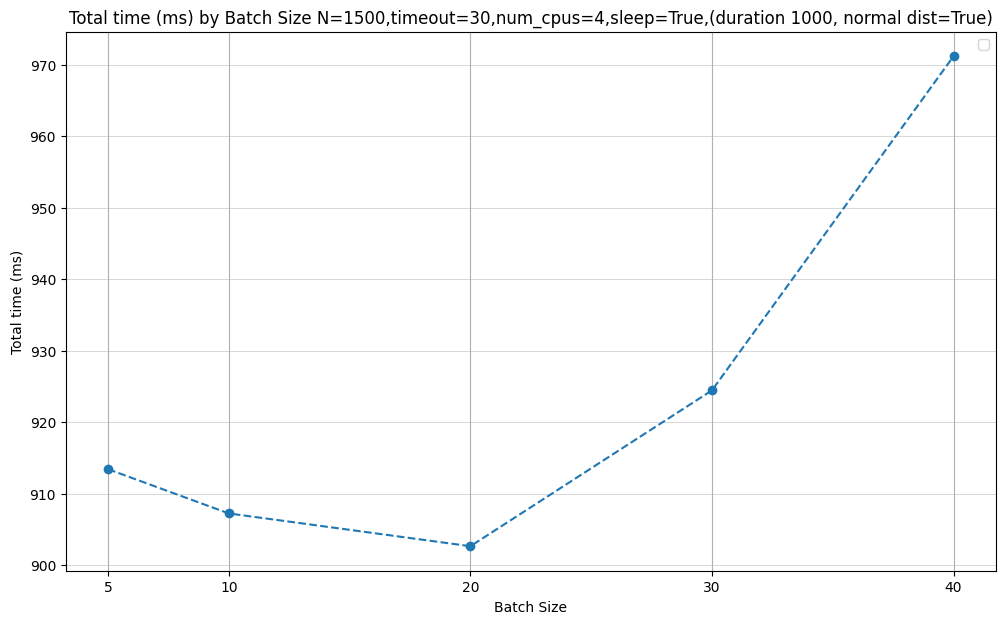

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


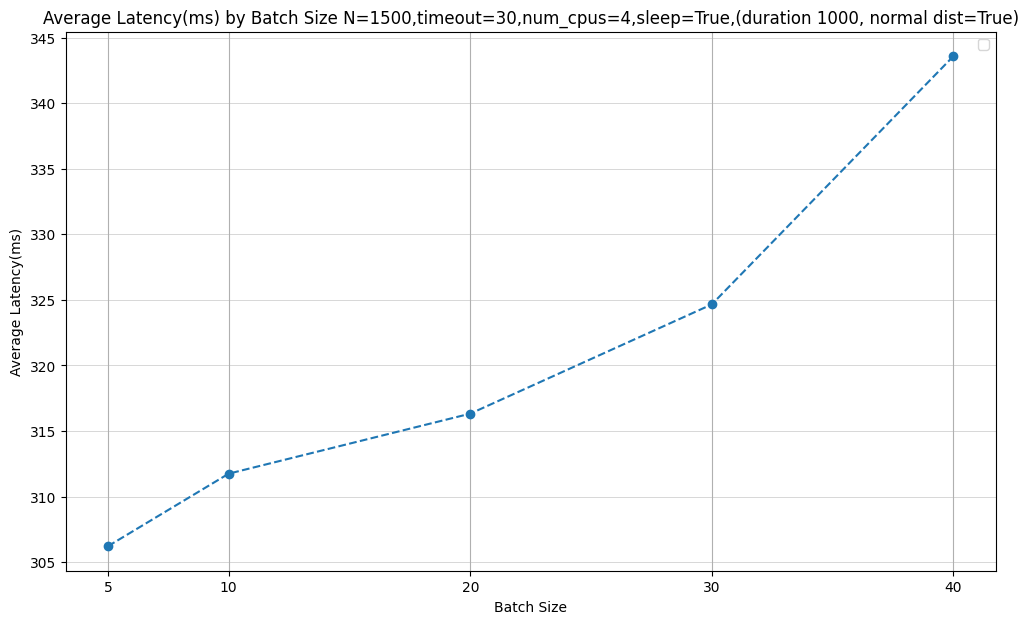

In [11]:
Clear()

Set(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 913.424542,"avg latency": 306.20769,"cumulative": 459324,"hmean": 84,"avg": 306,"p50": 297,"p75": 454,"p95": 596,"p99": 620,"p999": 643,"Long5": 611,"Short5": 10,"MaxM": 648,"MinM": 5,"RangM": 642,"StdDevM": 181,"RateSec": 3.2656679960194537,"HistogramM":""" &[map[5.882ms - 70.105ms:216] map[70.105ms - 134.327ms:108] map[134.327ms - 198.55ms:90] map[198.55ms - 262.772ms:219] map[262.772ms - 326.995ms:194] map[326.995ms - 391.217ms:173] map[391.217ms - 455.44ms:126] map[455.44ms - 519.662ms:121] map[519.662ms - 583.885ms:142] map[583.885ms - 648.107ms:111]]""","HistogramBinSize": 64.222485,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 303,"avg batch size": 4.930693069306931,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 227,"failed requests": 1122,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 8,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 907.235292,"avg latency": 311.743539,"cumulative": 467615,"hmean": 117,"avg": 311,"p50": 318,"p75": 455,"p95": 555,"p99": 588,"p999": 593,"Long5": 574,"Short5": 17,"MaxM": 594,"MinM": 8,"RangM": 585,"StdDevM": 169,"RateSec": 3.207764947729072,"HistogramM":""" &[map[8.344ms - 66.921ms:187] map[66.921ms - 125.498ms:53] map[125.498ms - 184.075ms:133] map[184.075ms - 242.653ms:185] map[242.653ms - 301.23ms:144] map[301.23ms - 359.807ms:176] map[359.807ms - 418.385ms:139] map[418.385ms - 476.962ms:144] map[476.962ms - 535.539ms:176] map[535.539ms - 594.117ms:163]]""","HistogramBinSize": 58.577328,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.551282051282051,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 147,"failed requests": 1417,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 902.652625,"avg latency": 316.322404,"cumulative": 475013,"hmean": 166,"avg": 316,"p50": 326,"p75": 473,"p95": 547,"p99": 563,"p999": 585,"Long5": 559,"Short5": 35,"MaxM": 603,"MinM": 16,"RangM": 587,"StdDevM": 166,"RateSec": 3.157802013104954,"HistogramM":""" &[map[16.516ms - 75.24ms:196] map[75.24ms - 133.963ms:84] map[133.963ms - 192.686ms:103] map[192.686ms - 251.41ms:177] map[251.41ms - 310.133ms:140] map[310.133ms - 368.857ms:173] map[368.857ms - 427.58ms:120] map[427.58ms - 486.303ms:199] map[486.303ms - 545.027ms:219] map[545.027ms - 603.75ms:89]]""","HistogramBinSize": 58.723401,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 78,"avg batch size": 18.96153846153846,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 78,"failed requests": 1499,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 9,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 924.444333,"avg latency": 324.659433,"cumulative": 486989,"hmean": 199,"avg": 324,"p50": 316,"p75": 462,"p95": 599,"p99": 643,"p999": 656,"Long5": 627,"Short5": 46,"MaxM": 659,"MinM": 7,"RangM": 651,"StdDevM": 166,"RateSec": 3.080150753812885,"HistogramM":""" &[map[7.82ms - 72.968ms:103] map[72.968ms - 138.117ms:105] map[138.117ms - 203.265ms:211] map[203.265ms - 268.414ms:207] map[268.414ms - 333.562ms:170] map[333.562ms - 398.711ms:180] map[398.711ms - 463.86ms:150] map[463.86ms - 529.008ms:167] map[529.008ms - 594.157ms:120] map[594.157ms - 659.305ms:87]]""","HistogramBinSize": 65.148552,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 54,"avg batch size": 27.185185185185187,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 53,"failed requests": 1493,"recent batches": [30,2,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 29,"timeouts triggered": 9,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 971.166458,"avg latency": 343.593331,"cumulative": 515389,"hmean": 217,"avg": 343,"p50": 333,"p75": 474,"p95": 638,"p99": 679,"p999": 697,"Long5": 666,"Short5": 49,"MaxM": 701,"MinM": 12,"RangM": 688,"StdDevM": 172,"RateSec": 2.910417369891724,"HistogramM":""" &[map[12.999ms - 81.853ms:89] map[81.853ms - 150.707ms:134] map[150.707ms - 219.56ms:196] map[219.56ms - 288.414ms:184] map[288.414ms - 357.268ms:212] map[357.268ms - 426.122ms:173] map[426.122ms - 494.976ms:175] map[494.976ms - 563.83ms:147] map[563.83ms - 632.683ms:103] map[632.683ms - 701.537ms:87]]""","HistogramBinSize": 68.853833,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 41,"avg batch size": 35.5609756097561,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 41,"failed requests": 1498,"recent batches": [40,40,40,17,40,10,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 38,"timeouts triggered": 8,})

analyse_data(duration=1000, use_normal=True, Y_values = [
    ('total time','Total time (ms)'),
    ('avg latency','Average Latency(ms)'),
    # ('avg batch size','Average batch size'),
    # ('cumulative','Cumulative'),
    # ('p75','p75'),
    ])

# Total time by number of messages (normal vs N = Batch)

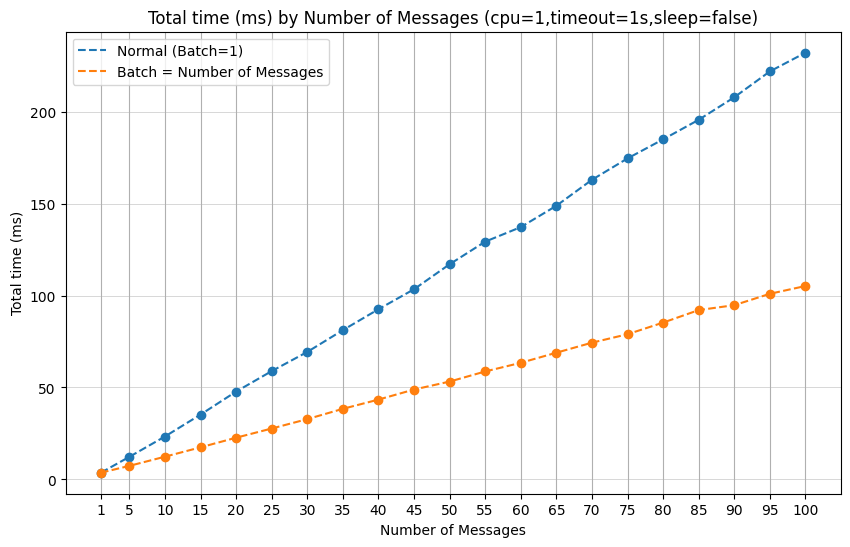

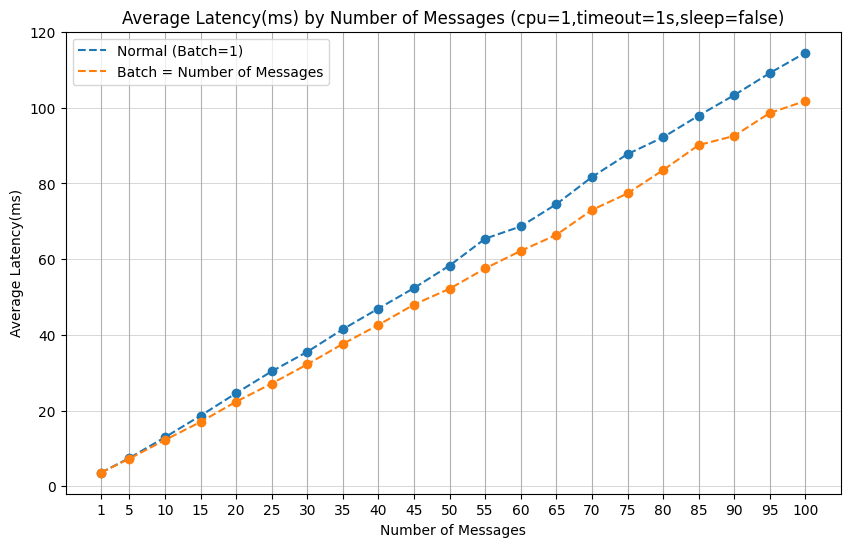

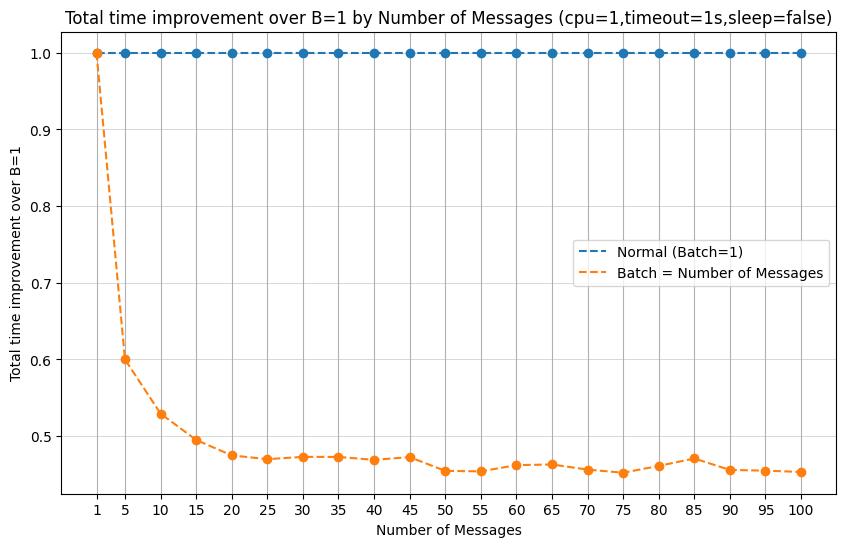

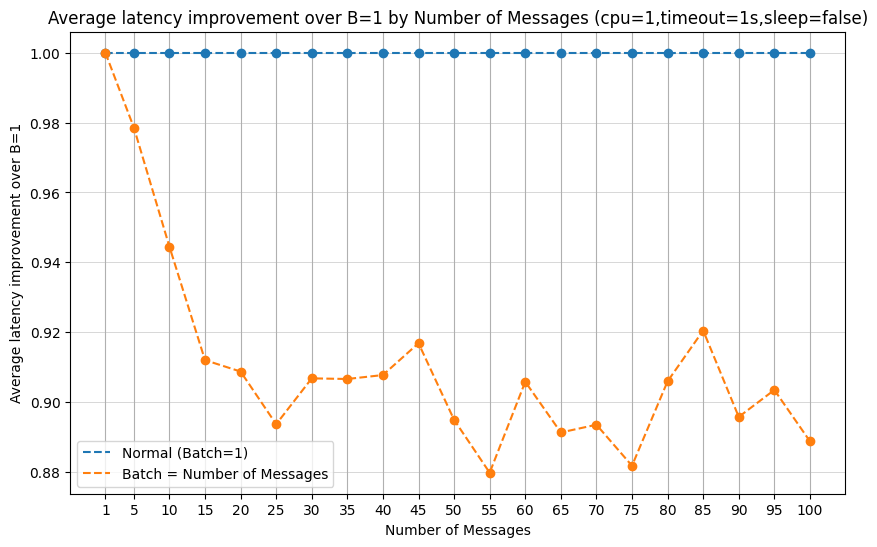

In [13]:
# Total time by number of messages (normal vs N = Batch)
Clear()

def Set1to5():
    # batch = 1 & [1,2,3,4,5], timeout = 1000, cpu = 1, sleep = False, N = [1,2,3,4,5]
    
    Set(batch=1,N=1,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 3.869208,"avg latency": 3.854041,"cumulative": 3,"hmean": 3,"avg": 3,"p50": 3,"p75": 3,"p95": 3,"p99": 3,"p999": 3,"Long5": 3,"Short5": 3,"MaxM": 3,"MinM": 3,"RangM": 0,"StdDevM": 0,"RateSec": 259.467919516165,"HistogramM":""" &[map[3.854ms - 3.854ms:1]]""","HistogramBinSize": 0*pow(10,3),"Samples": 1,"Count": 1,})
    "================================================================================================================"
    Set(batch=2,N=2,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 4.073916,"avg latency": 4.053208,"cumulative": 8,"hmean": 4,"avg": 4,"p50": 4,"p75": 4,"p95": 4,"p99": 4,"p999": 4,"Long5": 4,"Short5": 4,"MaxM": 4,"MinM": 4,"RangM": 0,"StdDevM": 0,"RateSec": 246.71812466592826,"HistogramM":""" &[map[4.043ms - 4.045ms:1] map[4.045ms - 4.047ms:1]]""","HistogramBinSize": 2.008*pow(10,-3),"Samples": 2,"Count": 2,})
    "================================================================================================================"
    Set(batch=3,N=3,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 5.066958,"avg latency": 5.005402,"cumulative": 15,"hmean": 5,"avg": 5,"p50": 4,"p75": 4,"p95": 5,"p99": 5,"p999": 5,"Long5": 5,"Short5": 4,"MaxM": 5,"MinM": 4,"RangM": 0,"StdDevM": 0,"RateSec": 199.78412659174674,"HistogramM":""" &[map[4.994ms - 4.998ms:2] map[4.998ms - 5.001ms:1]]""","HistogramBinSize": 3.104*pow(10,-3),"Samples": 3,"Count": 3,})
    "================================================================================================================"
    Set(batch=4,N=4,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 6.352625,"avg latency": 6.106792,"cumulative": 24,"hmean": 6,"avg": 6,"p50": 6,"p75": 6,"p95": 6,"p99": 6,"p999": 6,"Long5": 6,"Short5": 5,"MaxM": 6,"MinM": 5,"RangM": 0,"StdDevM": 0,"RateSec": 163.7520976643711,"HistogramM":""" &[map[5.998ms - 6.032ms:2] map[6.032ms - 6.067ms:1] map[6.067ms - 6.101ms:1]]""","HistogramBinSize": 34.516*pow(10,-3),"Samples": 4,"Count": 4,})
    "================================================================================================================"
    Set(batch=5,N=5,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 7.658291,"avg latency": 7.392883,"cumulative": 36,"hmean": 7,"avg": 7,"p50": 7,"p75": 7,"p95": 7,"p99": 7,"p999": 7,"Long5": 7,"Short5": 7,"MaxM": 7,"MinM": 7,"RangM": 0,"StdDevM": 0,"RateSec": 135.2652237221873,"HistogramM":""" &[map[7.036ms - 7.096ms:2] map[7.096ms - 7.155ms:1] map[7.155ms - 7.215ms:1] map[7.215ms - 7.275ms:1]]""","HistogramBinSize": 59.825*pow(10,-3),"Samples": 5,"Count": 5,})
    "================================================================================================================"

    Set(batch=1,N=1,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 3.78225,"avg latency": 3.771083,"cumulative": 3,"hmean": 3,"avg": 3,"p50": 3,"p75": 3,"p95": 3,"p99": 3,"p999": 3,"Long5": 3,"Short5": 3,"MaxM": 3,"MinM": 3,"RangM": 0,"StdDevM": 0,"RateSec": 265.175812889825,"HistogramM":""" &[map[3.771ms - 3.771ms:1]]""","HistogramBinSize": 0*pow(10,3),"Samples": 1,"Count": 1,})
    "================================================================================================================"
    Set(batch=1,N=2,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 5.249625,"avg latency": 4.047145,"cumulative": 8,"hmean": 3,"avg": 4,"p50": 5,"p75": 5,"p95": 5,"p99": 5,"p999": 5,"Long5": 5,"Short5": 2,"MaxM": 5,"MinM": 2,"RangM": 2,"StdDevM": 1,"RateSec": 247.08773134052137,"HistogramM":""" &[map[2.863ms - 3.1ms:1] map[3.1ms - 3.337ms:1]]""","HistogramBinSize": 236.637*pow(10,-3),"Samples": 2,"Count": 2,})
    "================================================================================================================"
    Set(batch=1,N=3,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 7.845542,"avg latency": 5.375749,"cumulative": 16,"hmean": 4,"avg": 5,"p50": 5,"p75": 5,"p95": 7,"p99": 7,"p999": 7,"Long5": 7,"Short5": 2,"MaxM": 7,"MinM": 2,"RangM": 5,"StdDevM": 2,"RateSec": 186.0205668059072,"HistogramM":""" &[map[2.802ms - 3.303ms:1] map[3.303ms - 3.803ms:1] map[3.803ms - 4.304ms:1]]""","HistogramBinSize": 500.491*pow(10,-3),"Samples": 3,"Count": 3,})
    "================================================================================================================"
    Set(batch=1,N=4,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 9.527333,"avg latency": 6.08825,"cumulative": 24,"hmean": 4,"avg": 6,"p50": 7,"p75": 7,"p95": 9,"p99": 9,"p999": 9,"Long5": 9,"Short5": 2,"MaxM": 9,"MinM": 2,"RangM": 6,"StdDevM": 2,"RateSec": 164.25081098837924,"HistogramM":""" &[map[2.657ms - 3.343ms:1] map[3.343ms - 4.028ms:1] map[4.028ms - 4.714ms:1] map[4.714ms - 5.399ms:1]]""","HistogramBinSize": 685.454*pow(10,-3),"Samples": 4,"Count": 4,})
    "================================================================================================================"
    Set(batch=1,N=5,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 12.75525,"avg latency": 7.737016,"cumulative": 38,"hmean": 5,"avg": 7,"p50": 7,"p75": 10,"p95": 12,"p99": 12,"p999": 12,"Long5": 12,"Short5": 2,"MaxM": 12,"MinM": 2,"RangM": 9,"StdDevM": 3,"RateSec": 129.24878897762193,"HistogramM":""" &[map[2.844ms - 3.827ms:1] map[3.827ms - 4.81ms:1] map[4.81ms - 5.793ms:1] map[5.793ms - 6.776ms:1] map[6.776ms - 7.758ms:1]]""","HistogramBinSize": 982.991*pow(10,-3),"Samples": 5,"Count": 5,})
    "================================================================================================================"

def Set1to100():
    # batch = 1 & [1,5,10,...,100], timeout = 1000, cpu = 1, sleep = False, N = [1,5,10,...,100]
    Set(batch=1,N=1,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 3.604625,"avg latency": 3.552916,"cumulative": 3,"hmean": 3,"avg": 3,"p50": 3,"p75": 3,"p95": 3,"p99": 3,"p999": 3,"Long5": 3,"Short5": 3,"MaxM": 3,"MinM": 3,"RangM": 0,"StdDevM": 0,"RateSec": 281.4589480865858,"HistogramM":""" &[map[3.552ms - 3.552ms:1]]""","HistogramBinSize": 0*pow(10,3),"Samples": 1,"Count": 1,})
    "================================================================================================================"
    Set(batch=1,N=5,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 12.268042,"avg latency": 7.452525,"cumulative": 37,"hmean": 5,"avg": 7,"p50": 7,"p75": 9,"p95": 12,"p99": 12,"p999": 12,"Long5": 12,"Short5": 2,"MaxM": 12,"MinM": 2,"RangM": 9,"StdDevM": 3,"RateSec": 134.18270628591767,"HistogramM":""" &[map[2.748ms - 3.698ms:1] map[3.698ms - 4.648ms:1] map[4.648ms - 5.598ms:1] map[5.598ms - 6.548ms:1] map[6.548ms - 7.498ms:1]]""","HistogramBinSize": 950.112*pow(10,-3),"Samples": 5,"Count": 5,})
    "================================================================================================================"
    Set(batch=1,N=10,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 23.336167,"avg latency": 12.9367,"cumulative": 129,"hmean": 8,"avg": 12,"p50": 14,"p75": 18,"p95": 23,"p99": 23,"p999": 23,"Long5": 23,"Short5": 2,"MaxM": 23,"MinM": 2,"RangM": 20,"StdDevM": 6,"RateSec": 77.2994658606909,"HistogramM":""" &[map[2.699ms - 4.744ms:1] map[4.744ms - 6.789ms:1] map[6.789ms - 8.835ms:1] map[8.835ms - 10.88ms:1] map[10.88ms - 12.925ms:1] map[12.925ms - 14.97ms:1] map[14.97ms - 17.015ms:1] map[17.015ms - 19.06ms:1] map[19.06ms - 21.105ms:1] map[21.105ms - 23.15ms:1]]""","HistogramBinSize": 2.045112,"Samples": 10,"Count": 10,})
    "================================================================================================================"
    Set(batch=1,N=15,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 35.242958,"avg latency": 18.6391,"cumulative": 279,"hmean": 11,"avg": 18,"p50": 18,"p75": 25,"p95": 32,"p99": 34,"p999": 34,"Long5": 34,"Short5": 2,"MaxM": 34,"MinM": 2,"RangM": 32,"StdDevM": 9,"RateSec": 53.65065909834703,"HistogramM":""" &[map[2.684ms - 5.886ms:2] map[5.886ms - 9.089ms:1] map[9.089ms - 12.291ms:2] map[12.291ms - 15.493ms:1] map[15.493ms - 18.696ms:2] map[18.696ms - 21.898ms:1] map[21.898ms - 25.1ms:1] map[25.1ms - 28.303ms:2] map[28.303ms - 31.505ms:1] map[31.505ms - 34.707ms:2]]""","HistogramBinSize": 3.202316,"Samples": 15,"Count": 15,})
    "================================================================================================================"
    Set(batch=1,N=20,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 47.764125,"avg latency": 24.584022,"cumulative": 491,"hmean": 13,"avg": 24,"p50": 25,"p75": 35,"p95": 44,"p99": 46,"p999": 46,"Long5": 46,"Short5": 2,"MaxM": 46,"MinM": 2,"RangM": 44,"StdDevM": 13,"RateSec": 40.67682519258641,"HistogramM":""" &[map[2.683ms - 7.104ms:2] map[7.104ms - 11.526ms:2] map[11.526ms - 15.947ms:2] map[15.947ms - 20.368ms:2] map[20.368ms - 24.789ms:2] map[24.789ms - 29.211ms:2] map[29.211ms - 33.632ms:2] map[33.632ms - 38.053ms:2] map[38.053ms - 42.474ms:2] map[42.474ms - 46.895ms:2]]""","HistogramBinSize": 4.421216,"Samples": 20,"Count": 20,})
    "================================================================================================================"
    Set(batch=1,N=25,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 58.903792,"avg latency": 30.364548,"cumulative": 759,"hmean": 16,"avg": 30,"p50": 30,"p75": 44,"p95": 55,"p99": 57,"p999": 57,"Long5": 57,"Short5": 2,"MaxM": 57,"MinM": 2,"RangM": 54,"StdDevM": 16,"RateSec": 32.93314264973482,"HistogramM":""" &[map[2.789ms - 8.261ms:3] map[8.261ms - 13.732ms:2] map[13.732ms - 19.204ms:3] map[19.204ms - 24.675ms:2] map[24.675ms - 30.147ms:2] map[30.147ms - 35.618ms:3] map[35.618ms - 41.089ms:2] map[41.089ms - 46.561ms:3] map[46.561ms - 52.032ms:2] map[52.032ms - 57.504ms:3]]""","HistogramBinSize": 5.471449,"Samples": 25,"Count": 25,})
    "================================================================================================================"
    Set(batch=1,N=30,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 69.33275,"avg latency": 35.521618,"cumulative": 1065,"hmean": 18,"avg": 35,"p50": 36,"p75": 52,"p95": 65,"p99": 68,"p999": 68,"Long5": 68,"Short5": 3,"MaxM": 68,"MinM": 2,"RangM": 65,"StdDevM": 19,"RateSec": 28.15187078471482,"HistogramM":""" &[map[2.732ms - 9.263ms:3] map[9.263ms - 15.795ms:3] map[15.795ms - 22.326ms:3] map[22.326ms - 28.858ms:3] map[28.858ms - 35.389ms:3] map[35.389ms - 41.921ms:3] map[41.921ms - 48.452ms:2] map[48.452ms - 54.983ms:4] map[54.983ms - 61.515ms:3] map[61.515ms - 68.046ms:3]]""","HistogramBinSize": 6.531437,"Samples": 30,"Count": 30,})
    "================================================================================================================"
    Set(batch=1,N=35,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 81.182625,"avg latency": 41.495602,"cumulative": 1452,"hmean": 20,"avg": 41,"p50": 41,"p75": 59,"p95": 75,"p99": 79,"p999": 79,"Long5": 78,"Short5": 4,"MaxM": 79,"MinM": 2,"RangM": 76,"StdDevM": 22,"RateSec": 24.098939183563168,"HistogramM":""" &[map[2.799ms - 10.473ms:4] map[10.473ms - 18.146ms:3] map[18.146ms - 25.82ms:4] map[25.82ms - 33.494ms:3] map[33.494ms - 41.168ms:3] map[41.168ms - 48.842ms:4] map[48.842ms - 56.516ms:3] map[56.516ms - 64.189ms:4] map[64.189ms - 71.863ms:3] map[71.863ms - 79.537ms:4]]""","HistogramBinSize": 7.673833,"Samples": 35,"Count": 35,})
    "================================================================================================================"
    Set(batch=1,N=40,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 92.558542,"avg latency": 46.958144,"cumulative": 1878,"hmean": 22,"avg": 46,"p50": 48,"p75": 68,"p95": 86,"p99": 90,"p999": 90,"Long5": 90,"Short5": 3,"MaxM": 90,"MinM": 2,"RangM": 88,"StdDevM": 26,"RateSec": 21.295560279339103,"HistogramM":""" &[map[2.729ms - 11.535ms:4] map[11.535ms - 20.342ms:4] map[20.342ms - 29.148ms:4] map[29.148ms - 37.955ms:4] map[37.955ms - 46.761ms:4] map[46.761ms - 55.568ms:4] map[55.568ms - 64.374ms:4] map[64.374ms - 73.181ms:4] map[73.181ms - 81.987ms:4] map[81.987ms - 90.793ms:4]]""","HistogramBinSize": 8.806437,"Samples": 40,"Count": 40,})
    "================================================================================================================"
    Set(batch=1,N=45,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 103.439708,"avg latency": 52.370613,"cumulative": 2356,"hmean": 25,"avg": 52,"p50": 53,"p75": 77,"p95": 97,"p99": 101,"p999": 101,"Long5": 100,"Short5": 3,"MaxM": 101,"MinM": 2,"RangM": 98,"StdDevM": 29,"RateSec": 19.094678146610082,"HistogramM":""" &[map[2.789ms - 12.669ms:5] map[12.669ms - 22.55ms:4] map[22.55ms - 32.431ms:5] map[32.431ms - 42.311ms:4] map[42.311ms - 52.192ms:4] map[52.192ms - 62.072ms:5] map[62.072ms - 71.953ms:4] map[71.953ms - 81.833ms:5] map[81.833ms - 91.714ms:4] map[91.714ms - 101.595ms:5]]""","HistogramBinSize": 9.880587,"Samples": 45,"Count": 45,})
    "================================================================================================================"
    Set(batch=1,N=50,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 117.035,"avg latency": 58.315545,"cumulative": 2915,"hmean": 26,"avg": 58,"p50": 59,"p75": 86,"p95": 109,"p99": 114,"p999": 114,"Long5": 113,"Short5": 5,"MaxM": 114,"MinM": 2,"RangM": 112,"StdDevM": 32,"RateSec": 17.148086317534656,"HistogramM":""" &[map[2.752ms - 13.96ms:5] map[13.96ms - 25.168ms:5] map[25.168ms - 36.376ms:5] map[36.376ms - 47.584ms:5] map[47.584ms - 58.792ms:5] map[58.792ms - 70ms:5] map[70ms - 81.208ms:5] map[81.208ms - 92.417ms:5] map[92.417ms - 103.625ms:5] map[103.625ms - 114.833ms:5]]""","HistogramBinSize": 11.20812,"Samples": 50,"Count": 50,})
    "================================================================================================================"
    Set(batch=1,N=55,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 129.33125,"avg latency": 65.418222,"cumulative": 3598,"hmean": 31,"avg": 65,"p50": 65,"p75": 95,"p95": 119,"p99": 124,"p999": 127,"Long5": 124,"Short5": 5,"MaxM": 127,"MinM": 3,"RangM": 124,"StdDevM": 36,"RateSec": 15.286260573865668,"HistogramM":""" &[map[3.294ms - 15.701ms:6] map[15.701ms - 28.109ms:5] map[28.109ms - 40.516ms:6] map[40.516ms - 52.924ms:5] map[52.924ms - 65.331ms:5] map[65.331ms - 77.739ms:6] map[77.739ms - 90.146ms:5] map[90.146ms - 102.554ms:6] map[102.554ms - 114.962ms:5] map[114.962ms - 127.369ms:6]]""","HistogramBinSize": 12.40757,"Samples": 55,"Count": 55,})
    "================================================================================================================"
    Set(batch=1,N=60,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 137.233,"avg latency": 68.658911,"cumulative": 4119,"hmean": 30,"avg": 68,"p50": 69,"p75": 100,"p95": 127,"p99": 132,"p999": 134,"Long5": 132,"Short5": 5,"MaxM": 134,"MinM": 2,"RangM": 131,"StdDevM": 38,"RateSec": 14.564751807060166,"HistogramM":""" &[map[2.757ms - 15.924ms:6] map[15.924ms - 29.091ms:6] map[29.091ms - 42.258ms:6] map[42.258ms - 55.426ms:6] map[55.426ms - 68.593ms:6] map[68.593ms - 81.76ms:6] map[81.76ms - 94.927ms:6] map[94.927ms - 108.094ms:5] map[108.094ms - 121.261ms:7] map[121.261ms - 134.428ms:6]]""","HistogramBinSize": 13.167091,"Samples": 60,"Count": 60,})
    "================================================================================================================"
    Set(batch=1,N=65,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 148.845375,"avg latency": 74.525656,"cumulative": 4844,"hmean": 34,"avg": 74,"p50": 74,"p75": 109,"p95": 138,"p99": 142,"p999": 145,"Long5": 143,"Short5": 5,"MaxM": 145,"MinM": 3,"RangM": 142,"StdDevM": 41,"RateSec": 13.418197808462356,"HistogramM":""" &[map[3.003ms - 17.225ms:7] map[17.225ms - 31.446ms:6] map[31.446ms - 45.668ms:7] map[45.668ms - 59.89ms:6] map[59.89ms - 74.112ms:6] map[74.112ms - 88.333ms:7] map[88.333ms - 102.555ms:6] map[102.555ms - 116.777ms:6] map[116.777ms - 130.999ms:7] map[130.999ms - 145.22ms:7]]""","HistogramBinSize": 14.22177,"Samples": 65,"Count": 65,})
    "================================================================================================================"
    Set(batch=1,N=70,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 162.975625,"avg latency": 81.697957,"cumulative": 5718,"hmean": 35,"avg": 81,"p50": 83,"p75": 121,"p95": 153,"p99": 158,"p999": 159,"Long5": 157,"Short5": 6,"MaxM": 159,"MinM": 2,"RangM": 156,"StdDevM": 46,"RateSec": 12.240208133072636,"HistogramM":""" &[map[2.882ms - 18.554ms:8] map[18.554ms - 34.227ms:7] map[34.227ms - 49.899ms:6] map[49.899ms - 65.571ms:7] map[65.571ms - 81.244ms:7] map[81.244ms - 96.916ms:6] map[96.916ms - 112.589ms:7] map[112.589ms - 128.261ms:7] map[128.261ms - 143.933ms:7] map[143.933ms - 159.606ms:8]]""","HistogramBinSize": 15.672395,"Samples": 70,"Count": 70,})
    "================================================================================================================"
    Set(batch=1,N=75,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 174.6065,"avg latency": 87.754134,"cumulative": 6581,"hmean": 40,"avg": 87,"p50": 88,"p75": 128,"p95": 162,"p99": 168,"p999": 170,"Long5": 166,"Short5": 7,"MaxM": 170,"MinM": 3,"RangM": 166,"StdDevM": 48,"RateSec": 11.3954744888699,"HistogramM":""" &[map[3.593ms - 20.281ms:8] map[20.281ms - 36.968ms:7] map[36.968ms - 53.656ms:8] map[53.656ms - 70.344ms:6] map[70.344ms - 87.031ms:8] map[87.031ms - 103.719ms:7] map[103.719ms - 120.406ms:8] map[120.406ms - 137.094ms:8] map[137.094ms - 153.781ms:7] map[153.781ms - 170.469ms:8]]""","HistogramBinSize": 16.687587,"Samples": 75,"Count": 75,})
    "================================================================================================================"
    Set(batch=1,N=80,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 184.975083,"avg latency": 92.19863,"cumulative": 7375,"hmean": 42,"avg": 92,"p50": 93,"p75": 135,"p95": 171,"p99": 178,"p999": 180,"Long5": 177,"Short5": 6,"MaxM": 180,"MinM": 4,"RangM": 175,"StdDevM": 51,"RateSec": 10.846148116874254,"HistogramM":""" &[map[4.687ms - 22.272ms:9] map[22.272ms - 39.858ms:8] map[39.858ms - 57.444ms:8] map[57.444ms - 75.029ms:7] map[75.029ms - 92.615ms:8] map[92.615ms - 110.2ms:8] map[110.2ms - 127.786ms:8] map[127.786ms - 145.372ms:8] map[145.372ms - 162.957ms:8] map[162.957ms - 180.543ms:8]]""","HistogramBinSize": 17.585591,"Samples": 80,"Count": 80,})
    "================================================================================================================"
    Set(batch=1,N=85,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 195.613917,"avg latency": 97.933768,"cumulative": 8324,"hmean": 43,"avg": 97,"p50": 97,"p75": 144,"p95": 182,"p99": 189,"p999": 191,"Long5": 188,"Short5": 6,"MaxM": 191,"MinM": 2,"RangM": 188,"StdDevM": 54,"RateSec": 10.210982573838272,"HistogramM":""" &[map[2.941ms - 21.786ms:8] map[21.786ms - 40.631ms:9] map[40.631ms - 59.476ms:8] map[59.476ms - 78.321ms:9] map[78.321ms - 97.166ms:8] map[97.166ms - 116.011ms:8] map[116.011ms - 134.856ms:9] map[134.856ms - 153.701ms:9] map[153.701ms - 172.545ms:8] map[172.545ms - 191.39ms:9]]""","HistogramBinSize": 18.844941,"Samples": 85,"Count": 85,})
    "================================================================================================================"
    Set(batch=1,N=90,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 207.871875,"avg latency": 103.346723,"cumulative": 9301,"hmean": 46,"avg": 103,"p50": 104,"p75": 153,"p95": 193,"p99": 200,"p999": 202,"Long5": 200,"Short5": 7,"MaxM": 202,"MinM": 4,"RangM": 197,"StdDevM": 58,"RateSec": 9.67616552875442,"HistogramM":""" &[map[4.862ms - 24.632ms:10] map[24.632ms - 44.402ms:9] map[44.402ms - 64.172ms:8] map[64.172ms - 83.941ms:9] map[83.941ms - 103.711ms:9] map[103.711ms - 123.481ms:9] map[123.481ms - 143.251ms:9] map[143.251ms - 163.02ms:9] map[163.02ms - 182.79ms:9] map[182.79ms - 202.56ms:9]]""","HistogramBinSize": 19.769766,"Samples": 90,"Count": 90,})
    "================================================================================================================"
    Set(batch=1,N=95,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 221.936,"avg latency": 109.175903,"cumulative": 10371,"hmean": 49,"avg": 109,"p50": 108,"p75": 161,"p95": 205,"p99": 213,"p999": 216,"Long5": 211,"Short5": 8,"MaxM": 216,"MinM": 5,"RangM": 210,"StdDevM": 62,"RateSec": 9.159530300489465,"HistogramM":""" &[map[5.692ms - 26.745ms:11] map[26.745ms - 47.798ms:10] map[47.798ms - 68.852ms:9] map[68.852ms - 89.905ms:9] map[89.905ms - 110.958ms:9] map[110.958ms - 132.011ms:10] map[132.011ms - 153.065ms:9] map[153.065ms - 174.118ms:9] map[174.118ms - 195.171ms:10] map[195.171ms - 216.224ms:9]]""","HistogramBinSize": 21.053262,"Samples": 95,"Count": 95,})
    "================================================================================================================"
    Set(batch=1,N=100,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 232.10825,"avg latency": 114.544263,"cumulative": 11454,"hmean": 50,"avg": 114,"p50": 115,"p75": 169,"p95": 215,"p99": 224,"p999": 226,"Long5": 222,"Short5": 7,"MaxM": 226,"MinM": 5,"RangM": 221,"StdDevM": 65,"RateSec": 8.73024948837737,"HistogramM":""" &[map[5.109ms - 27.293ms:11] map[27.293ms - 49.477ms:10] map[49.477ms - 71.66ms:10] map[71.66ms - 93.844ms:10] map[93.844ms - 116.028ms:10] map[116.028ms - 138.211ms:9] map[138.211ms - 160.395ms:10] map[160.395ms - 182.579ms:10] map[182.579ms - 204.763ms:10] map[204.763ms - 226.946ms:10]]""","HistogramBinSize": 22.183716,"Samples": 100,"Count": 100,})
    "================================================================================================================"

    Set(batch=1,N=1,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 3.661417,"avg latency": 3.609916,"cumulative": 3,"hmean": 3,"avg": 3,"p50": 3,"p75": 3,"p95": 3,"p99": 3,"p999": 3,"Long5": 3,"Short5": 3,"MaxM": 3,"MinM": 3,"RangM": 0,"StdDevM": 0,"RateSec": 277.0147560220238,"HistogramM":""" &[map[3.609ms - 3.609ms:1]]""","HistogramBinSize": 0*pow(10,3),"Samples": 1,"Count": 1,})
    "================================================================================================================"
    Set(batch=5,N=5,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 7.359917,"avg latency": 7.292858,"cumulative": 36,"hmean": 7,"avg": 7,"p50": 7,"p75": 7,"p95": 7,"p99": 7,"p999": 7,"Long5": 7,"Short5": 7,"MaxM": 7,"MinM": 7,"RangM": 0,"StdDevM": 0,"RateSec": 137.12045025090436,"HistogramM":""" &[map[7.254ms - 7.263ms:1] map[7.263ms - 7.272ms:1] map[7.272ms - 7.281ms:1] map[7.281ms - 7.29ms:1] map[7.29ms - 7.299ms:1]]""","HistogramBinSize": 8.845*pow(10,-3),"Samples": 5,"Count": 5,})
    "================================================================================================================"
    Set(batch=10,N=10,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 12.353583,"avg latency": 12.218379,"cumulative": 122,"hmean": 12,"avg": 12,"p50": 12,"p75": 12,"p95": 12,"p99": 12,"p999": 12,"Long5": 12,"Short5": 11,"MaxM": 12,"MinM": 11,"RangM": 0,"StdDevM": 0,"RateSec": 81.84391592626295,"HistogramM":""" &[map[11.902ms - 11.945ms:1] map[11.945ms - 11.989ms:1] map[11.989ms - 12.033ms:1] map[12.033ms - 12.077ms:1] map[12.077ms - 12.121ms:1] map[12.121ms - 12.165ms:1] map[12.165ms - 12.208ms:1] map[12.208ms - 12.252ms:1] map[12.252ms - 12.296ms:1] map[12.296ms - 12.34ms:1]]""","HistogramBinSize": 43.845*pow(10,-3),"Samples": 10,"Count": 10,})
    "================================================================================================================"
    Set(batch=15,N=15,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 17.444791,"avg latency": 16.998619,"cumulative": 254,"hmean": 16,"avg": 16,"p50": 17,"p75": 17,"p95": 17,"p99": 17,"p999": 17,"Long5": 17,"Short5": 16,"MaxM": 17,"MinM": 16,"RangM": 0,"StdDevM": 0,"RateSec": 58.82830696238778,"HistogramM":""" &[map[16.698ms - 16.768ms:3] map[16.768ms - 16.839ms:1] map[16.839ms - 16.91ms:1] map[16.91ms - 16.98ms:1] map[16.98ms - 17.051ms:3] map[17.051ms - 17.122ms:4] map[17.122ms - 17.192ms:1] map[17.192ms - 17.263ms:1]]""","HistogramBinSize": 70.67*pow(10,-3),"Samples": 15,"Count": 15,})
    "================================================================================================================"
    Set(batch=20,N=20,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 22.680667,"avg latency": 22.339972,"cumulative": 446,"hmean": 22,"avg": 22,"p50": 22,"p75": 22,"p95": 22,"p99": 22,"p999": 22,"Long5": 22,"Short5": 21,"MaxM": 22,"MinM": 21,"RangM": 0,"StdDevM": 0,"RateSec": 44.762811586125935,"HistogramM":""" &[map[21.845ms - 21.924ms:1] map[21.924ms - 22.004ms:1] map[22.004ms - 22.083ms:1] map[22.083ms - 22.162ms:2] map[22.162ms - 22.241ms:3] map[22.241ms - 22.32ms:2] map[22.321ms - 22.4ms:1] map[22.4ms - 22.479ms:1] map[22.479ms - 22.558ms:3] map[22.558ms - 22.637ms:5]]""","HistogramBinSize": 79.229*pow(10,-3),"Samples": 20,"Count": 20,})
    "================================================================================================================"
    Set(batch=25,N=25,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 27.678584,"avg latency": 27.134946,"cumulative": 678,"hmean": 27,"avg": 27,"p50": 27,"p75": 27,"p95": 27,"p99": 27,"p999": 27,"Long5": 27,"Short5": 26,"MaxM": 27,"MinM": 26,"RangM": 0,"StdDevM": 0,"RateSec": 36.85284591260096,"HistogramM":""" &[map[26.626ms - 26.72ms:4] map[26.72ms - 26.814ms:2] map[26.814ms - 26.908ms:1] map[26.908ms - 27.002ms:1] map[27.002ms - 27.096ms:5] map[27.096ms - 27.19ms:2] map[27.19ms - 27.284ms:1] map[27.284ms - 27.378ms:1] map[27.378ms - 27.472ms:3] map[27.472ms - 27.567ms:5]]""","HistogramBinSize": 94.079*pow(10,-3),"Samples": 25,"Count": 25,})
    "================================================================================================================"
    Set(batch=30,N=30,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 32.788959,"avg latency": 32.209973,"cumulative": 966,"hmean": 32,"avg": 32,"p50": 32,"p75": 32,"p95": 32,"p99": 32,"p999": 32,"Long5": 32,"Short5": 31,"MaxM": 32,"MinM": 31,"RangM": 1,"StdDevM": 0,"RateSec": 31.046284339864343,"HistogramM":""" &[map[31.52ms - 31.643ms:4] map[31.643ms - 31.766ms:1] map[31.766ms - 31.889ms:4] map[31.889ms - 32.012ms:3] map[32.012ms - 32.135ms:1] map[32.135ms - 32.258ms:1] map[32.258ms - 32.381ms:5] map[32.381ms - 32.504ms:1] map[32.504ms - 32.628ms:4] map[32.628ms - 32.751ms:6]]""","HistogramBinSize": 123.083*pow(10,-3),"Samples": 30,"Count": 30,})
    "================================================================================================================"
    Set(batch=35,N=35,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 38.387167,"avg latency": 37.619519,"cumulative": 1316,"hmean": 37,"avg": 37,"p50": 37,"p75": 37,"p95": 38,"p99": 38,"p999": 38,"Long5": 38,"Short5": 36,"MaxM": 38,"MinM": 36,"RangM": 1,"StdDevM": 0,"RateSec": 26.58194537895383,"HistogramM":""" &[map[36.75ms - 36.91ms:5] map[36.91ms - 37.069ms:1] map[37.069ms - 37.228ms:5] map[37.228ms - 37.388ms:1] map[37.388ms - 37.547ms:3] map[37.547ms - 37.706ms:4] map[37.706ms - 37.866ms:1] map[37.866ms - 38.025ms:6] map[38.025ms - 38.184ms:1] map[38.184ms - 38.344ms:8]]""","HistogramBinSize": 159.325*pow(10,-3),"Samples": 35,"Count": 35,})
    "================================================================================================================"
    Set(batch=40,N=40,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 43.412,"avg latency": 42.624867,"cumulative": 1704,"hmean": 42,"avg": 42,"p50": 42,"p75": 42,"p95": 43,"p99": 43,"p999": 43,"Long5": 43,"Short5": 41,"MaxM": 43,"MinM": 41,"RangM": 1,"StdDevM": 0,"RateSec": 23.460483305322718,"HistogramM":""" &[map[41.796ms - 41.952ms:5] map[41.952ms - 42.107ms:1] map[42.107ms - 42.262ms:8] map[42.262ms - 42.418ms:1] map[42.418ms - 42.573ms:5] map[42.573ms - 42.728ms:2] map[42.728ms - 42.884ms:3] map[42.884ms - 43.039ms:5] map[43.039ms - 43.194ms:1] map[43.194ms - 43.35ms:9]]""","HistogramBinSize": 155.362*pow(10,-3),"Samples": 40,"Count": 40,})
    "================================================================================================================"
    Set(batch=45,N=45,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 48.88725,"avg latency": 48.014998,"cumulative": 2160,"hmean": 48,"avg": 48,"p50": 48,"p75": 48,"p95": 48,"p99": 48,"p999": 48,"Long5": 48,"Short5": 46,"MaxM": 48,"MinM": 46,"RangM": 1,"StdDevM": 0,"RateSec": 20.82682575057634,"HistogramM":""" &[map[46.975ms - 47.162ms:2] map[47.162ms - 47.349ms:6] map[47.349ms - 47.536ms:1] map[47.536ms - 47.723ms:9] map[47.723ms - 47.91ms:1] map[47.91ms - 48.097ms:5] map[48.097ms - 48.284ms:3] map[48.284ms - 48.47ms:6] map[48.47ms - 48.657ms:2] map[48.657ms - 48.844ms:10]]""","HistogramBinSize": 186.879*pow(10,-3),"Samples": 45,"Count": 45,})
    "================================================================================================================"
    Set(batch=50,N=50,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 53.213416,"avg latency": 52.186377,"cumulative": 2609,"hmean": 52,"avg": 52,"p50": 52,"p75": 52,"p95": 53,"p99": 53,"p999": 53,"Long5": 53,"Short5": 51,"MaxM": 53,"MinM": 51,"RangM": 2,"StdDevM": 0,"RateSec": 19.162088803730438,"HistogramM":""" &[map[51.114ms - 51.321ms:7] map[51.321ms - 51.528ms:3] map[51.528ms - 51.735ms:6] map[51.735ms - 51.942ms:3] map[51.942ms - 52.149ms:5] map[52.149ms - 52.355ms:3] map[52.355ms - 52.562ms:5] map[52.562ms - 52.769ms:8] map[52.769ms - 52.976ms:1] map[52.976ms - 53.183ms:9]]""","HistogramBinSize": 206.833*pow(10,-3),"Samples": 50,"Count": 50,})
    "================================================================================================================"
    Set(batch=55,N=55,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 58.715917,"avg latency": 57.551935,"cumulative": 3165,"hmean": 57,"avg": 57,"p50": 57,"p75": 58,"p95": 58,"p99": 58,"p999": 58,"Long5": 58,"Short5": 56,"MaxM": 58,"MinM": 56,"RangM": 2,"StdDevM": 0,"RateSec": 17.375610229654214,"HistogramM":""" &[map[56.337ms - 56.569ms:7] map[56.569ms - 56.801ms:3] map[56.801ms - 57.032ms:6] map[57.032ms - 57.264ms:4] map[57.264ms - 57.496ms:8] map[57.496ms - 57.728ms:4] map[57.728ms - 57.96ms:5] map[57.96ms - 58.192ms:4] map[58.192ms - 58.423ms:5] map[58.423ms - 58.655ms:9]]""","HistogramBinSize": 231.82*pow(10,-3),"Samples": 55,"Count": 55,})
    "================================================================================================================"
    Set(batch=60,N=60,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 63.418417,"avg latency": 62.190902,"cumulative": 3731,"hmean": 62,"avg": 62,"p50": 62,"p75": 62,"p95": 63,"p99": 63,"p999": 63,"Long5": 63,"Short5": 60,"MaxM": 63,"MinM": 60,"RangM": 2,"StdDevM": 0,"RateSec": 16.07952237129476,"HistogramM":""" &[map[60.958ms - 61.2ms:8] map[61.2ms - 61.441ms:7] map[61.441ms - 61.682ms:2] map[61.682ms - 61.923ms:7] map[61.923ms - 62.164ms:5] map[62.164ms - 62.406ms:5] map[62.406ms - 62.647ms:8] map[62.647ms - 62.888ms:3] map[62.888ms - 63.129ms:5] map[63.129ms - 63.371ms:10]]""","HistogramBinSize": 241.237*pow(10,-3),"Samples": 60,"Count": 60,})
    "================================================================================================================"
    Set(batch=65,N=65,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 68.918917,"avg latency": 66.422807,"cumulative": 4385,"hmean": 67,"avg": 67,"p50": 67,"p75": 68,"p95": 68,"p99": 68,"p999": 68,"Long5": 68,"Short5": 66,"MaxM": 68,"MinM": 65,"RangM": 2,"StdDevM": 0,"RateSec": 14.822611528749174,"HistogramM":""" &[map[65.915ms - 66.21ms:5] map[66.21ms - 66.505ms:6] map[66.505ms - 66.799ms:8] map[66.799ms - 67.094ms:4] map[67.094ms - 67.389ms:6] map[67.389ms - 67.684ms:7] map[67.684ms - 67.978ms:9] map[67.978ms - 68.273ms:6] map[68.273ms - 68.568ms:7] map[68.568ms - 68.863ms:7]]""","HistogramBinSize": 294.779*pow(10,-3),"Samples": 65,"Count": 65,})
    "================================================================================================================"
    Set(batch=70,N=70,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 74.3695,"avg latency": 72.996905,"cumulative": 5109,"hmean": 72,"avg": 72,"p50": 73,"p75": 73,"p95": 74,"p99": 74,"p999": 74,"Long5": 74,"Short5": 71,"MaxM": 74,"MinM": 71,"RangM": 2,"StdDevM": 0,"RateSec": 13.699210873611953,"HistogramM":""" &[map[71.496ms - 71.781ms:7] map[71.781ms - 72.066ms:7] map[72.066ms - 72.35ms:7] map[72.35ms - 72.635ms:6] map[72.635ms - 72.92ms:5] map[72.92ms - 73.205ms:8] map[73.205ms - 73.49ms:7] map[73.49ms - 73.775ms:3] map[73.775ms - 74.059ms:11] map[74.059ms - 74.344ms:9]]""","HistogramBinSize": 284.833*pow(10,-3),"Samples": 70,"Count": 70,})
    "================================================================================================================"
    Set(batch=75,N=75,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 78.964417,"avg latency": 77.376578,"cumulative": 5803,"hmean": 77,"avg": 77,"p50": 77,"p75": 78,"p95": 78,"p99": 78,"p999": 78,"Long5": 78,"Short5": 75,"MaxM": 78,"MinM": 75,"RangM": 3,"StdDevM": 0,"RateSec": 12.923807458432467,"HistogramM":""" &[map[75.802ms - 76.11ms:8] map[76.11ms - 76.418ms:8] map[76.418ms - 76.726ms:6] map[76.726ms - 77.034ms:8] map[77.034ms - 77.342ms:7] map[77.342ms - 77.65ms:5] map[77.65ms - 77.958ms:8] map[77.958ms - 78.266ms:7] map[78.266ms - 78.574ms:8] map[78.574ms - 78.882ms:10]]""","HistogramBinSize": 308.02*pow(10,-3),"Samples": 75,"Count": 75,})
    "================================================================================================================"
    Set(batch=80,N=80,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 85.295834,"avg latency": 83.525787,"cumulative": 6682,"hmean": 83,"avg": 83,"p50": 83,"p75": 84,"p95": 85,"p99": 85,"p999": 85,"Long5": 85,"Short5": 81,"MaxM": 85,"MinM": 81,"RangM": 3,"StdDevM": 1,"RateSec": 11.97235045344943,"HistogramM":""" &[map[81.557ms - 81.922ms:4] map[81.922ms - 82.288ms:7] map[82.288ms - 82.654ms:10] map[82.654ms - 83.019ms:8] map[83.019ms - 83.385ms:8] map[83.385ms - 83.751ms:8] map[83.751ms - 84.116ms:9] map[84.116ms - 84.482ms:8] map[84.482ms - 84.847ms:8] map[84.847ms - 85.213ms:10]]""","HistogramBinSize": 365.608*pow(10,-3),"Samples": 80,"Count": 80,})
    "================================================================================================================"
    Set(batch=85,N=85,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 92.1005,"avg latency": 90.145286,"cumulative": 7662,"hmean": 90,"avg": 90,"p50": 90,"p75": 91,"p95": 91,"p99": 92,"p999": 92,"Long5": 91,"Short5": 88,"MaxM": 92,"MinM": 88,"RangM": 3,"StdDevM": 1,"RateSec": 11.09320338189356,"HistogramM":""" &[map[88.089ms - 88.482ms:9] map[88.482ms - 88.875ms:9] map[88.875ms - 89.267ms:9] map[89.267ms - 89.66ms:8] map[89.66ms - 90.053ms:6] map[90.053ms - 90.446ms:8] map[90.446ms - 90.839ms:6] map[90.839ms - 91.231ms:10] map[91.231ms - 91.624ms:10] map[91.624ms - 92.017ms:10]]""","HistogramBinSize": 392.795*pow(10,-3),"Samples": 85,"Count": 85,})
    "================================================================================================================"
    Set(batch=90,N=90,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 94.774291,"avg latency": 92.57104,"cumulative": 8331,"hmean": 92,"avg": 92,"p50": 92,"p75": 93,"p95": 94,"p99": 94,"p999": 94,"Long5": 94,"Short5": 90,"MaxM": 94,"MinM": 90,"RangM": 4,"StdDevM": 1,"RateSec": 10.802514455054942,"HistogramM":""" &[map[90.53ms - 90.938ms:10] map[90.938ms - 91.346ms:10] map[91.346ms - 91.754ms:7] map[91.754ms - 92.162ms:11] map[92.162ms - 92.57ms:9] map[92.57ms - 92.978ms:8] map[92.978ms - 93.387ms:7] map[93.387ms - 93.795ms:9] map[93.795ms - 94.203ms:9] map[94.203ms - 94.611ms:10]]""","HistogramBinSize": 408.091*pow(10,-3),"Samples": 90,"Count": 90,})
    "================================================================================================================"
    Set(batch=95,N=95,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 100.963875,"avg latency": 98.635042,"cumulative": 9370,"hmean": 98,"avg": 98,"p50": 98,"p75": 99,"p95": 100,"p99": 100,"p999": 100,"Long5": 100,"Short5": 96,"MaxM": 100,"MinM": 96,"RangM": 4,"StdDevM": 1,"RateSec": 10.138384644248514,"HistogramM":""" &[map[96.18ms - 96.655ms:9] map[96.655ms - 97.129ms:9] map[97.129ms - 97.604ms:8] map[97.604ms - 98.079ms:12] map[98.079ms - 98.553ms:7] map[98.553ms - 99.028ms:10] map[99.028ms - 99.503ms:8] map[99.503ms - 99.977ms:9] map[99.977ms - 100.452ms:11] map[100.452ms - 100.927ms:12]]""","HistogramBinSize": 474.654*pow(10,-3),"Samples": 95,"Count": 95,})
    "================================================================================================================"
    Set(batch=100,N=100,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 105.202708,"avg latency": 101.80327,"cumulative": 10283,"hmean": 102,"avg": 102,"p50": 102,"p75": 103,"p95": 105,"p99": 105,"p999": 105,"Long5": 105,"Short5": 100,"MaxM": 105,"MinM": 100,"RangM": 4,"StdDevM": 1,"RateSec": 9.724364388947402,"HistogramM":""" &[map[100.462ms - 100.927ms:11] map[100.927ms - 101.393ms:10] map[101.393ms - 101.859ms:8] map[101.859ms - 102.325ms:11] map[102.325ms - 102.79ms:9] map[102.79ms - 103.256ms:10] map[103.256ms - 103.722ms:8] map[103.722ms - 104.188ms:9] map[104.188ms - 104.654ms:13] map[104.654ms - 105.119ms:11]]""","HistogramBinSize": 465.791*pow(10,-3),"Samples": 100,"Count": 100,})
    "================================================================================================================"


contex = [#{"f":Set1to5,"suffix":'1to5'},
          {"f":Set1to100,"suffix":'1to100'},
          ]


for ctx in contex:

    Clear()
    ctx['f']()
    file_path_suffix = ctx['suffix']

    keys = FindKeys(batch = 1)
    keys2 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 2))
    keys5 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 5))
    keys10 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 10))
    keys20 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 20))
    keys50 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 50))
    keys100 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 100))
    keys500 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 500))
    keys1000 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 1000))
    keysN = [k for k in FindKeys() if k[BATCH] == k[N_ENTRY]]
    
    for keys_lst in [keys,keys2,keys5,keys10,keys20,keys50,keys100,keys500,keys1000,keysN]:
        for elm in keys_lst:
            base = GetElementsFromEntryList([k for k in keys if k[BATCH] == 1 and k[N_ENTRY] == elm[N_ENTRY]])[0]
            elm_entry = GetElementsFromEntryList([elm])[0]
            elm_entry['total time to B=1'] = elm_entry['total time'] / base['total time']
            elm_entry['avg latency to B=1'] = elm_entry['avg latency'] / base['avg latency']
    


    Y_descriptor = ['total time', 'avg latency', 'total time to B=1','avg latency to B=1']
    Y_label = ['Total time (ms)', 'Average Latency(ms)', 'Total time improvement over B=1','Average latency improvement over B=1']

    for y_index in range(len(Y_descriptor)):

        y_descriptor = Y_descriptor[y_index]
        y_label = Y_label[y_index]


        xx = []
        yy = []
        stddev = []
        labels = []

        keys = FindKeys(batch = 1)
        y = [v[y_descriptor] for v in GetElementsFromEntryList(keys)]
        x = [v[N_ENTRY] for v in keys]
        xx += [x]
        yy += [y]
        labels += ['Normal (Batch=1)']

        keys = FindKeys()
        keys = [k for k in keys if k[BATCH] == k[N_ENTRY]]
        y = [v[y_descriptor] for v in GetElementsFromEntryList(keys)]
        x = [v[N_ENTRY] for v in keys]
        xx += [x]
        yy += [y]
        labels += ['Batch = Number of Messages']


        x_label = 'Number of Messages'
        y_label = y_label
        title = f'{y_label} by Number of Messages (cpu=1,timeout=1s,sleep=false)'

        stddev = None
        horizontal_grid_only = True
        file_path = f"{y_label}_by_number_messages_{file_path_suffix}.png"
        curve_line = False
        extra_y_value = None
        extra_value_label = None
        x_ticks = x
        line_type = '--'
        put_point = True
        fig_size = (10,6)

        line_plot(xx,yy,
                    labels = labels,
                    x_label=x_label,
                    y_label=y_label,
                    title=title,
                    stddev=stddev,
                    horizontal_grid_only = horizontal_grid_only,
                    file_path = file_path,
                    curve_line = curve_line,
                    extra_y_value = extra_y_value,
                    extra_value_label = extra_value_label,
                    x_ticks = x_ticks,
                    line_type = line_type,
                    put_point = put_point,
                    fig_size=fig_size)